<span style="font-size:32px; font-weight:bold;">Прогнозирование покупок в интернет-магазине

# Введение

**Описание**  
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.  
**Цель**  
Предсказать вероятность покупки в течение 90 дней  
**Задачи**  
● Изучить данные  
● Разработать полезные признаки  
● Создать модель для классификации пользователей  
● Улучшить модель и максимизировать метрику roc_auc  
● Выполнить тестирование  

**Данные**  
- apparel-purchases (история покупок)  
  ● client_id идентификатор пользователя  
  ● quantity количество товаров в заказе  
  ● price цена товара  
  ● category_ids вложенные категории, к которым отнсится товар  
  ● date дата покупки  
  ● message_id идентификатор сообщения из рассылки  
- apparel-messages (история рекламных рассылок)  
  ● bulk_campaign_id идентификатор рекламной кампании  
  ● client_id идентификатор пользователя  
  ● message_id идентификатор сообщений  
  ● event тип действия  
  ● channel канал рассылки  
  ● date дата рассылки  
  ● created_at точное время создания сообщения  
- apparel-target_binary (совершит ли клиент покупку в течение следующих 90 дней)  
  ● client_id идентификатор пользователя  
  ● target целевой признак  
- full_campaign_daily_event (Агрегация общей базы рассылок по дням и типам событий)  
  ● date дата  
  ● bulk_campaign_id идентификатор рассылки  
  ● count_event* общее количество каждого события event  
  ● nunique_event* количество уникальных client_id в каждом событии  
  `*` в именах колонок найдете все типы событий event  
- full_campaign_daily_event_channel (Агрегация по дням с учетом событий и каналов рассылки)  
  ● date дата  
  ● bulk_campaign_id идентификатор рассылки  
  ● count_event*_channel* общее количество каждого события по каналам  
  ● nunique_event*_channel* количество уникальных client_id по событиям и каналам  
  `*` в именах колонок есть все типы событий event и каналов рассылки channel
    

**План работы**  
1) Загрузка, анализ и предобработка данных
2) Генерация признаков
3) Объединение данных
   - Undersampling
   - Корреляционный анализ
   - Разделение на выборки
4) Создание моделей МО
   - Подбор гиперпараметров
   - Анализ полученных метрик
   - Анализ графиков точности и полноты
   - Выбор лучшей модели
   - Анализ важности признаков
5) Общие выводы

## Установка и импорт библиотек, функции

In [1]:
!pip install shap -q

In [2]:
# Standard library imports
import ast
import time
from collections import Counter
from datetime import datetime, timedelta

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import statsmodels.api as sm
from phik import phik_matrix
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# scikit-learn components
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_recall_curve,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    QuantileTransformer,
)

# Other ML libraries
from catboost import CatBoostClassifier
from category_encoders.target_encoder import TargetEncoder
from imblearn.over_sampling import SMOTE

# Constants
RANDOM_STATE = 24
TEST_SIZE = 0.2


In [3]:
def load_and_check_csv(filepath, url='', sep=',', decimal='.'):
    try:
        df = pd.read_csv(filepath, sep=sep, decimal=decimal)
        source = filepath
    except:
        df = pd.read_csv(url, sep=sep, decimal=decimal)
        source = url
    
    # Проверим, загружены ли данные корректно
    print(f"Загружены данные из {source}")
    display(df.head())
    
    # Проверка типов данных
    df.info()
    
    print('='*70, '\n\n')
    
    return df

In [4]:
def plot_count_and_boxplot(df: pd.DataFrame, column: str) -> None:

    plt.figure(figsize=(12, 6))

    # График частот для дискретного признака
    plt.subplot(1, 2, 1)
    sns.countplot(x=df[column], palette='viridis')
    plt.title(f'Частотный график для {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')

    # Ящик с усами
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column], color='lightgreen')
    plt.title(f'Ящик с усами для {column}')

    plt.tight_layout()
    plt.show()

In [5]:
def calc_boxplot_stats(data: pd.Series):
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outliers = outliers.sort_values()
    outliers_len = len(outliers)
    
    statistics = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers_len': outliers_len,
        'outliers': outliers
    }
    
    return statistics

In [6]:
def plot_distr_and_boxplot(df: pd.DataFrame, column: str) -> None:
    # Рассчитываем среднее и стандартное отклонение для нормального распределения
    mean = df[column].mean()
    std = df[column].std()

    # Создаем сетку значений по оси X
    x = np.linspace(df[column].min(), df[column].max(), 100)
    y = norm.pdf(x, mean, std) * len(df[column]) * (df[column].max() - df[column].min()) / 40  # Подгоняем масштаб

    plt.figure(figsize=(12, 6))

    # Гистограмма с плотностью KDE
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=40, kde=True, color='skyblue')
    plt.axvline(mean, color='red', linestyle='--', label='среднее')
    plt.axvline(df[column].median(), color='orange', linestyle='-', label='медиана')
    plt.plot(x, y, color='green', label='Нормальное распределение')
    plt.title(f'Гистограмма распределения {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.legend()

    # Ящик с усами
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column], color='lightgreen')
    plt.title(f'Ящик с усами для {column}')

    plt.tight_layout()
    plt.show()

In [7]:
def top_category_ids_to_list(series, top=3):
    """ 
    Принимает на вход Series и возвращает список топ-N самых популярных значений из неё,
    с учётом вложенных списков 
    """
    all_categories = []
    
    for value in series:
        # Обрабатываем случаи, когда значение - список, кортеж или другой итерируемый объект
        if isinstance(value, (list, tuple)):
            all_categories.extend([item for item in value if item is not None and str(item) != '0'])
        # Пропускаем None и нулевые значения
        elif value is not None and str(value) != '0':
            all_categories.append(value)
    
    if not all_categories:
        return []
    
    counter = Counter(all_categories)
    return [item[0] for item in counter.most_common(top)]

In [8]:
def get_purchase_campaigns(series, purchase_events):
    """Возвращает уникальные campaign_id для event == 'purchase' """
    purchase_campaigns = series[purchase_events == 'purchase'].unique()
    return sorted(purchase_campaigns.tolist()) if len(purchase_campaigns) > 0 else []

In [9]:
def filter_zeros_and_none(lst):
    """ Функция для фильтрации нулей и None """
    if not isinstance(lst, list):
        return []
    return [x for x in lst if x is not None and str(x) != '0']
    
def clean_list(col):
    return col.apply(
        lambda x: list(set(filter_zeros_and_none(x))) if isinstance(x, list) else []
    )

In [10]:
def enrich_category_metrics(categories):
    """ Функция для подсчёта по списку категорий """
    if not categories:
        return pd.Series({'avg_client_category_frequency': 0.0}) # 'unique_clients_category': 0, 
    
    # Берм значения из словарей
    # uniques = [unique_clients_category_dict.get(cat, 0) for cat in categories]
    freqs = [avg_client_category_frequency_dict.get(cat, 0) for cat in categories]
    
    # # Сумма уникальных клиентов
    # total_clients = sum(uniques)

    # Расчёт по частоте - рассчитываем так: 
    # 'первое значение'+('второе'-1)+('третье'-1) и т.д. отнимая по 1 от каждого кроме первого
    if freqs:
        freq_sum = freqs[0] + sum(f - 1 for f in freqs[1:])
    else:
        freq_sum = 0.0
    
    return pd.Series({
        # 'unique_clients_categories': total_clients,
        'avg_client_categories_frequency': round(freq_sum, 2)
    })

In [11]:
""" функции для агрегации df_messages """

def last_non_purchase_campaign(df_group):
    non_purchase = df_group[df_group['event'] != 'purchase']
    if non_purchase.empty:
        return None
    return str(non_purchase.sort_values('created_at').iloc[-1]['bulk_campaign_id'])

def purchase_channels(df_group):
    # Получаем каналы только из purchase событий
    purchase_rows = df_group[df_group['event'] == 'purchase']
    purchase_channels = purchase_rows['channel'].unique()
    
    if len(purchase_channels) > 0:
        return sorted(purchase_channels)
    else:
        # Если нет purchase событий, берем самый частый канал из всех сообщений
        if not df_group.empty:
            most_frequent_channel = df_group['channel'].mode()
            if not most_frequent_channel.empty:
                return [most_frequent_channel[0]]
        return None 

def days_since_last_contact(date_series):
    last_date = date_series.max()
    if pd.isna(last_date):
        return None
    last_date = datetime.strptime(last_date, "%Y-%m-%d")
    return (upload_date - last_date).days

In [12]:
def clear_list(x):
    """ сортирует элементы, преобразует их в строки и объединяет через ';'. Возвращает str 'a;b;c...' """
    if isinstance(x, list):
        return ';'.join(map(str, sorted(x)))
    return str(x) if not pd.isna(x) else '0'

In [13]:
def reduce_to_top_k(series, k=20):
    top_k = series.value_counts().nlargest(k).index
    return series.where(series.isin(top_k), '0')


In [14]:
def calculate_vif(df, num_columns):
    X = df[num_columns]

    # Добавляем константный столбец для расчета VIF (обязательно для корректного расчета)
    X_with_const = sm.add_constant(X)

    # Рассчитаем VIF для каждого признака
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i+1)  # смещение +1 из-за константы
                       for i in range(len(X.columns))]

    return vif_data

In [15]:
class ListToStringTransformer(BaseEstimator, TransformerMixin):
    """Преобразует списки в строки с разделителем ';' с сортировкой"""
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        # Функция для обработки одного значения
        def process_value(x):
            if isinstance(x, list):
                return ';'.join(sorted(str(item) for item in x))
            return str(x)
        
        # Обрабатываем как DataFrame (даже если одна колонка)
        return X.applymap(process_value)

In [16]:
def reduce_rare_categories(df, column, threshold=30):
    """ Объединение редких категорий в категориальных признаках  """
    value_counts = df[column].value_counts()
    to_replace = value_counts[value_counts < threshold].index
    return df[column].apply(lambda x: '0' if x in to_replace else x)

In [17]:
def target_encode_with_cv(df, target_col, cat_cols, n_splits=5, random_state=RANDOM_STATE):
    """Target Encoding с кросс-валидацией без утечек и сохранением оригинальных названий колонок"""
    df_encoded = df.copy()
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for col in cat_cols:
        encoded_col = f'{col}_te'
        df_encoded[encoded_col] = np.nan

        for train_idx, val_idx in skf.split(df, df[target_col]):
            encoder = TargetEncoder(cols=[col])
            encoder.fit(df.iloc[train_idx][col], df.iloc[train_idx][target_col])
            df_encoded.iloc[val_idx, df_encoded.columns.get_loc(encoded_col)] = encoder.transform(df.iloc[val_idx][col])[col].values

        # # Удаляем оригинальный столбец и переименовываем encoded_col в оригинальное имя
        # df_encoded.drop(columns=col, inplace=True)
        # df_encoded.rename(columns={encoded_col: col}, inplace=True)

    return df_encoded


In [18]:
def undersample_weak_majority(df, target_col, encoded_cols, quantile=0.2):
    """ Undersampling по слабым значениям (где таргет-энкод значения низкие) """
    majority_df = df[df[target_col] == 0]
    minority_df = df[df[target_col] == 1]
    
    score = majority_df[encoded_cols].mean(axis=1)
    threshold = score.quantile(quantile)
    majority_df = majority_df[score > threshold]
    
    return pd.concat([majority_df, minority_df])

# Загрузка, анализ и предобработка данных

## target

In [19]:
df_target = load_and_check_csv('filtered_data/apparel-target_binary.csv')

Загружены данные из filtered_data/apparel-target_binary.csv


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB




In [20]:
df_target.client_id.nunique()

49849

In [21]:
df_target.target.value_counts()

0    48888
1      961
Name: target, dtype: int64

Всего в исходных данных 49849 уникальных клиента client_id.  
Отмечается сильный дисбаланс классов.

## apparel-purchases  
Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.

In [22]:
df_purchases = load_and_check_csv('filtered_data/apparel-purchases.csv')

Загружены данные из filtered_data/apparel-purchases.csv


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB




In [23]:
df_purchases_len = len(df_purchases)
df_purchases.duplicated().sum()

73020

In [24]:
# ##################### удаление ##############################
# df_purchases = df_purchases.drop_duplicates()

##################### суммирование вместо удаления ##############################
df_purchases = df_purchases.groupby(
    ["client_id", "price", "category_ids", "date", "message_id"], 
    as_index=False
)["quantity"].sum()

In [25]:
df_purchases.duplicated().sum()

0

In [26]:
round(len(df_purchases)/df_purchases_len*100, 1)

63.8

В исходных данных 73020 дубликата. Два варианта обработки дубликатов:  
- Удалить дубликаты. Несмотря на то, что это существенная часть данных, если это действительно ошибочные дубликаты, то их стоит уддалить, потому-что они не принесут пользы для обучения модели.  
- Суммировать по quantity. Вероятно это несколько покупок одного и того же товра (или с одинаковыми категориями и ценой) в один день. Для уменьшения размерности датасета можно просуммировать такие дубликаты по количеству товаров.

Тестирование показало, что больше информации сохраняется при суммировании. Поэтому остановимся на нем.  

После обработки дубликатов датасет составляет 63,8% от начального без потери информации.

In [27]:
df_purchases.client_id.nunique()

49849

49849 уникальных значений client_id. Аналогичное количество уникальных клиентов в df_target.

In [28]:
df_purchases['date'].agg(['min', 'max'])

min    2022-05-16
max    2024-02-16
Name: date, dtype: object

In [29]:
# Дата выгрузки
upload_date = datetime.strptime("2024-02-19", "%Y-%m-%d")

Датасет о покупка содержит диапазон дат от 2022-05-16 до 2024-02-16.  
Поскольку сведения о дате выгрузки отсутствуют, предположим, что дата выгрузки: 2024-02-19.

In [30]:
df_purchases['category_ids'] = df_purchases['category_ids'].apply(ast.literal_eval)

# Создаем новые столбцы для каждого уровня
max_levels = 5  # Максимальная наблюдаемая глубина категорий
for level in range(max_levels):
    df_purchases[f'category_level_{level+1}'] = df_purchases['category_ids'].apply(
        lambda x: x[level] if len(x) > level else '0'
    )

In [31]:
df_purchases['category_ids'].apply(len).max()

5

Преобразовали строковые значения category_ids в списки строк (категорий).  
Максимальная глубина цепочки категорий - 5.  
Создали столбцы для каждого уровня категорий.  

In [32]:
# df_purchases['deepest_category'] = df_purchases['category_ids'].apply(
#     lambda x: str(x[-1]) if x and x[-1] is not None else '0'
# )

mask_empty = df_purchases['category_ids'].apply(lambda x: isinstance(x, list) and len(x) == 0)
print(f"Строк с пустым списком: {len(df_purchases[mask_empty])}")
unique_empty_prices = df_purchases.loc[mask_empty, 'price'].unique()
price_to_unknown_cat = {price: f'unknwn_{i+1}' for i, price in enumerate(sorted(unique_empty_prices))}
print(f"Создано категорий: {len(price_to_unknown_cat)}")
df_purchases['deepest_category'] = df_purchases.apply(
    lambda row: (
        str(row['category_ids'][-1]) if isinstance(row['category_ids'], list) and row['category_ids']
        else price_to_unknown_cat.get(row['price'], 'unknwn_unknown')
    ),
    axis=1
)

Строк с пустым списком: 2738
Создано категорий: 69


Создали столбец deepest_category. Присвоили новые категории (69) по строкам с пустам списком категорий (2738). 

In [33]:
clients_per_category = df_purchases.groupby('deepest_category')['client_id'].nunique()

df_purchases_deep = df_purchases.groupby('deepest_category')['price'] \
    .agg(['count', 'mean']) \
    .sort_values('count') \
    .rename(columns={'mean': 'avg_price'})

df_purchases_deep['unique_clients_category'] = clients_per_category
df_purchases_deep['avg_client_category_frequency'] = (
    df_purchases_deep['count'] / df_purchases_deep['unique_clients_category']
).round(2)

# (df_purchases_deep['count']==1).sum()
df_purchases_deep.sample(5)

,count,avg_price,unique_clients_category,avg_client_category_frequency
deepest_category,,,,
1697,69,92.884058,50,1.38
856,20,74.850000,14,1.43
1275,24,1362.458333,17,1.41
559,11,1867.636364,11,1.00
unknwn_7,1326,7.000000,1319,1.01


In [34]:
unique_clients_category_dict = df_purchases_deep['unique_clients_category'].to_dict()
avg_client_category_frequency_dict = df_purchases_deep['avg_client_category_frequency'].to_dict()

Рассчитали для каждой категории количество уникальных клиентов и частоту покупки товара одним и темже клиентом.  

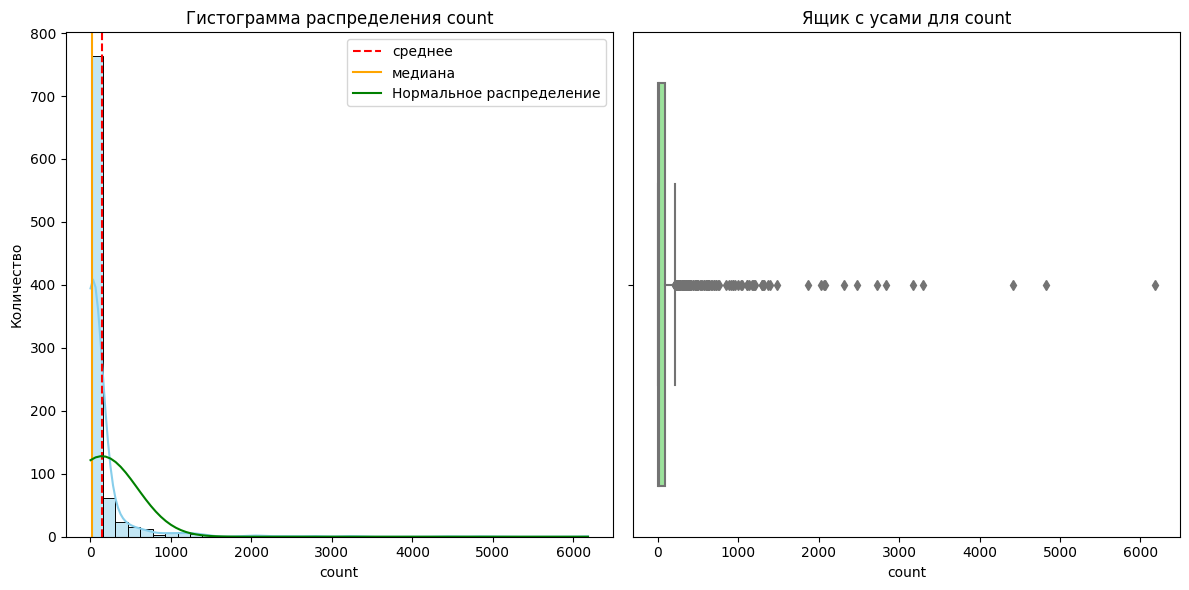

count     912.000000
mean      141.467105
std       439.232367
min         1.000000
25%         7.000000
50%        24.000000
75%        89.250000
max      6182.000000
Name: count, dtype: float64

In [35]:
plot_distr_and_boxplot(df_purchases_deep, 'count')
df_purchases_deep['count'].describe()

In [36]:
len(df_purchases_deep)

912

In [37]:
df_purchases_deep.iloc[-1]

count                            6182.000000
avg_price                        1439.218376
unique_clients_category          4265.000000
avg_client_category_frequency       1.450000
Name: 431, dtype: float64

In [38]:
df_purchases[df_purchases['deepest_category'] == '431']['client_id'].nunique()

4265

Таким образом, получили 912 самых глубоких категорий (наиболее узко определяет товар).  
Распределение категорий по популярности неравномерное, сильно смещено вправо.  
Самая популярная категория '431' - 6191 покупок, 4265 клиентов.  

In [39]:
df_purchases['total_price'] = df_purchases['price'] * df_purchases['quantity']

Создали столбец total_price с суммарной стоимостью покупки.  

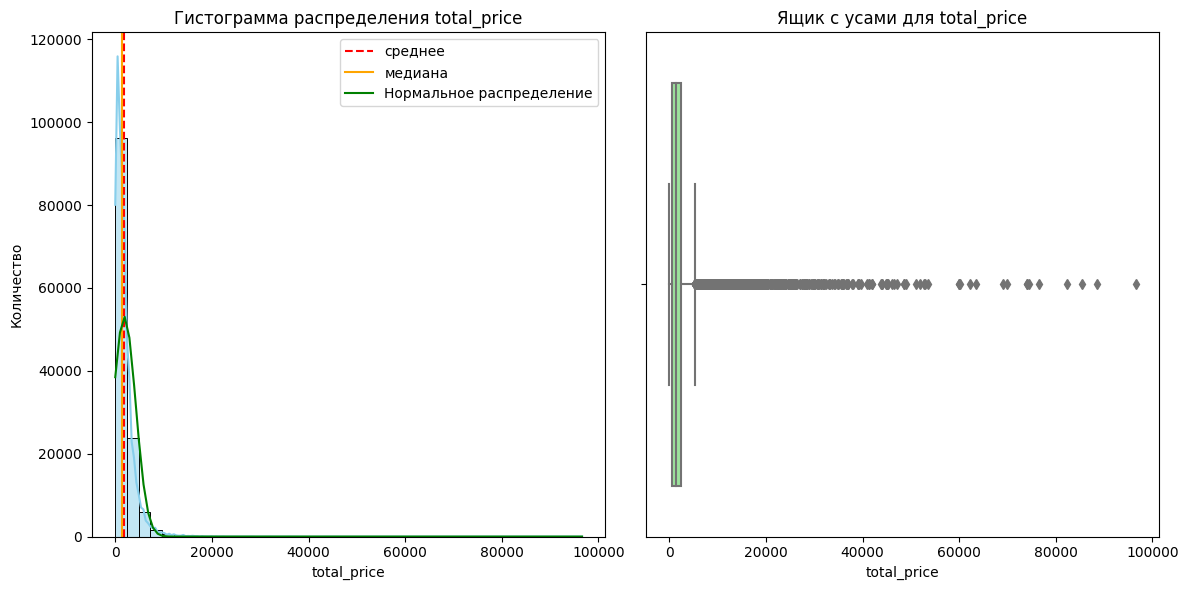

count    129018.000000
mean       1879.927685
std        2342.233193
min           1.000000
25%         560.000000
50%        1398.000000
75%        2498.000000
max       96598.000000
Name: total_price, dtype: float64

In [40]:
plot_distr_and_boxplot(df_purchases, 'total_price')
df_purchases['total_price'].describe()

In [41]:
stats = calc_boxplot_stats(df_purchases['total_price'])
stats

{'Q1': 560.0,
 'Q3': 2498.0,
 'IQR': 1938.0,
 'lower_bound': -2347.0,
 'upper_bound': 5405.0,
 'outliers_len': 6601,
 'outliers': 93703      5413.0
 44954      5415.0
 107870     5416.0
 88639      5416.0
 96212      5416.0
            ...   
 63763     76497.0
 102351    82320.0
 63766     85499.0
 63764     88497.0
 127309    96598.0
 Name: total_price, Length: 6601, dtype: float64}

Отмечается существенное количество значений total_price, более чем на полтора межквартильных размаха превышающих третий квартиль. Распределение сильно смещено вправо. 

In [42]:
df_purchases.category_level_2.nunique(), df_purchases.deepest_category.nunique()

(32, 912)

Для предачи в модель из столбцов с категорями по уровням оставим только столбц category_level_2. Именно уровень 2 имеет наилучшее обобщение при не слишком большом количестве категорий. 

In [43]:
df_purchases['bulk_campaign_id'] = df_purchases['message_id'].str.split('-').str[1].astype(int)

Выделили отдельные уровни по категориям, а также самый глубокий уровень.

In [44]:
agg_dict = {
    'total_price': 'sum',
    'category_ids': lambda x: top_category_ids_to_list(x, top=3),
    'deepest_category': lambda x: top_category_ids_to_list(x, top=2),
    'category_level_2': lambda x: top_category_ids_to_list(x, top=2),
    'bulk_campaign_id': lambda x: top_category_ids_to_list(x, top=2),
}

df_purchases_grouped = df_purchases.groupby('client_id').agg(agg_dict).reset_index()

df_purchases_grouped = df_purchases_grouped.rename(columns={
    'total_price': 'total_spent',
    'category_ids': 'category_ids_grpd',
    'deepest_category': 'all_deepest_categories',
    'category_level_2': 'all_categories_level_2',
    'bulk_campaign_id': 'all_purchase_campaign_ids'
})

# Обработка категорий (уникальные значения + фильтрация нулей)   
for col in ['all_deepest_categories', 'all_categories_level_2', 'all_purchase_campaign_ids', 'category_ids_grpd']:
    if col in df_purchases_grouped.columns:
        df_purchases_grouped[col] = clean_list(df_purchases_grouped[col])


df_purchases_grouped.head()

,client_id,total_spent,category_ids_grpd,all_deepest_categories,all_categories_level_2,all_purchase_campaign_ids
0,1515915625468060902,6993.0,"[4, 27, 28]","[458, 422]","[27, 28]",[4617]
1,1515915625468061003,16235.0,"[4, 249, 28]",[615],[28],[9148]
2,1515915625468061099,299.0,"[4, 290, 28]",[424],[28],[4439]
3,1515915625468061100,2098.0,"[4, 27, 1828]",[5717],[27],[14623]
4,1515915625468061170,33601.0,"[4, 260, 28]","[420, unknwn_7]","[18, 28]","[11208, 11144]"


Сгруппировали **df_purchases** по client_id. При этом получили по каждому клиенту следующие признаки:  
- client_id - id клиента    
- total_spent - сумма, потраченная клиентом    
- category_ids_grpd - список из трех наиболее популярных категории  
- all_deepest_categories - список из двух наиболее популярных самых глубоких категорий  
- all_categories_level_2 - список из двух наиболее популярных категорий уровня 2  
- all_purchase_campaign_ids - список из двух наиболее популярных id рассылок 

In [45]:
df_purchases_grouped['avg_client_categories_frequency'] = (  # 'unique_clients_categories', 
    df_purchases_grouped['all_deepest_categories'].apply(enrich_category_metrics)
)
df_purchases_grouped.head()

,client_id,total_spent,category_ids_grpd,all_deepest_categories,all_categories_level_2,all_purchase_campaign_ids,avg_client_categories_frequency
0,1515915625468060902,6993.0,"[4, 27, 28]","[458, 422]","[27, 28]",[4617],1.85
1,1515915625468061003,16235.0,"[4, 249, 28]",[615],[28],[9148],1.39
2,1515915625468061099,299.0,"[4, 290, 28]",[424],[28],[4439],1.41
3,1515915625468061100,2098.0,"[4, 27, 1828]",[5717],[27],[14623],1.10
4,1515915625468061170,33601.0,"[4, 260, 28]","[420, unknwn_7]","[18, 28]","[11208, 11144]",1.41


Добавили к df_purchases_grouped еще 1 признак:  
- avg_client_categories_frequency - условная частота повторных покупок по этим категориям: для первой категории берётся её средняя частота, а для каждой следующей — из частоты вычитается 1

<!-- - unique_clients_categories - суммарное количество уникальных клиентов, покупавших хотя бы один раз из категорий из списка all_deepest_categories данного клиента   -->

In [46]:
df_purchases['date'] = pd.to_datetime(df_purchases['date'])

purchase_stats = (
    df_purchases.groupby('client_id')['date']
    .agg([
        ('purchase_count', 'count'),
        ('last_purchase_date', 'max'),
        ('avg_days_between_purchases', lambda x: (
            x.drop_duplicates().sort_values().diff().mean().days
            if x.nunique() > 1 else (upload_date - x.iloc[0]).days + 180 # 90
        ))
    ])
    .reset_index()
)

purchase_stats.columns = ['client_id', 'purchase_count', 'last_purchase_date', 'avg_days_between_purchases']

# Добавляем дней с последней покупки
purchase_stats['days_since_last_purchase'] = (upload_date - purchase_stats['last_purchase_date']).dt.days

df_purchases_grouped = df_purchases_grouped.merge(
    purchase_stats[['client_id', 'purchase_count', 'days_since_last_purchase', 'avg_days_between_purchases']],
    on='client_id',
    how='left'
)
df_purchases_grouped.head()

,client_id,total_spent,category_ids_grpd,all_deepest_categories,all_categories_level_2,all_purchase_campaign_ids,avg_client_categories_frequency,purchase_count,days_since_last_purchase,avg_days_between_purchases
0,1515915625468060902,6993.0,"[4, 27, 28]","[458, 422]","[27, 28]",[4617],1.85,5,633,813
1,1515915625468061003,16235.0,"[4, 249, 28]",[615],[28],[9148],1.39,6,411,591
2,1515915625468061099,299.0,"[4, 290, 28]",[424],[28],[4439],1.41,1,643,823
3,1515915625468061100,2098.0,"[4, 27, 1828]",[5717],[27],[14623],1.10,1,9,189
4,1515915625468061170,33601.0,"[4, 260, 28]","[420, unknwn_7]","[18, 28]","[11208, 11144]",1.41,8,247,41


Добавили к df_purchases_grouped еще 3 признака:  
- purchase_count - количество покупок
- days_since_last_purchase - дней с момента последней покупки
- avg_days_between_purchases - дней между покупками в среднем (для клиентов с одной покупкой - это дней с момента единственной покупки + 180 дней)

In [47]:
df_purchases_grouped.columns

Index(['client_id', 'total_spent', 'category_ids_grpd',
       'all_deepest_categories', 'all_categories_level_2',
       'all_purchase_campaign_ids', 'avg_client_categories_frequency',
       'purchase_count', 'days_since_last_purchase',
       'avg_days_between_purchases'],
      dtype='object')

Таким образом, из датасета **apparel-purchases** получили аггрегированный по client_id датасет со следующими признаками:  
1) total_spent - сумма, потраченная клиентом    
2) category_ids_grpd - список из трех наиболее популярных категории  
3) all_deepest_categories - список из двух наиболее популярных самых глубоких категорий  
4) all_categories_level_2 - список из двух наиболее популярных категорий уровня 2  
5) all_purchase_campaign_ids - список из двух наиболее популярных id рассылок  
6) avg_client_categories_frequency - условная частота повторных покупок по этим категориям: для первой категории берётся её средняя частота, а для каждой следующей — из частоты вычитается 1  
7) purchase_count - количество покупок  
8) days_since_last_purchase - дней с момента последней покупки  
9) avg_days_between_purchases - дней между покупками в среднем (для клиентов с одной покупкой - это дней с момента единственной покупки + 90 дней)  

<!-- - unique_clients_categories - суммарное количество уникальных клиентов, покупавших хотя бы один раз из категорий из списка all_deepest_categories данного клиента   -->

## apparel-messages  
Рассылки, которые были отправлены клиентам из таблицы покупок. 

In [48]:
df_messages = load_and_check_csv('filtered_data/apparel-messages.csv')

Загружены данные из filtered_data/apparel-messages.csv


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB




In [49]:
df_messages.client_id.nunique()

53329

In [50]:
len(set(df_messages['client_id'].unique()) & set(df_target['client_id'].unique()))

41982

В df_messages есть информация только о 41982 пользователях, по которым имеется таргет (из 49849). При этом есть клиенты, таргет по которым отсутствует. Удалим строки по таким клиентам.   

In [51]:
df_messages = df_messages[df_messages['client_id'].isin(df_target['client_id'])]

In [52]:
df_messages.duplicated().sum()

37724

In [53]:
df_messages = df_messages.drop_duplicates()

Отмечается 37724 дубликата. Так как сообщения имеют уникальный номер, то дубликаты можно удалить без потери информации. 

In [54]:
df_messages['channel'].value_counts()

mobile_push    6088089
email          4825108
Name: channel, dtype: int64

In [55]:
df_messages_grouped = df_messages.groupby('client_id').apply(
    lambda x: pd.Series({
        'days_since_last_contact': days_since_last_contact(x['date']),
        'last_non_purchase_campaign_id': last_non_purchase_campaign(x),
        'total_messages': len(x),
        'purchase_channels': purchase_channels(x) # top_category_ids_to_list(x)
    })
).reset_index()
df_messages_grouped.head()

,client_id,days_since_last_contact,last_non_purchase_campaign_id,total_messages,purchase_channels
0,1515915625468060902,31,14502,177,[email]
1,1515915625468061003,6,14641,165,[email]
2,1515915625468061099,6,14624,276,[email]
3,1515915625468061100,4,14653,428,[mobile_push]
4,1515915625468061170,4,14657,293,[email]


Сгруппировали **df_messages** по client_id. При этом получили по каждому клиенту следующие признаки:
1) days_since_last_contact - дней с даты последнего контакта
2) last_non_purchase_campaign_id - ID кампании последнего контакта, где event не 'purchase'
3) Общее количество сообщений
4) Каналы связи сообщений с покупками (отсортированные по частоте)

## full_campaign_daily_event  
Агрегация общей базы рассылок по дням и типам событий 

In [56]:
df_event = load_and_check_csv('filtered_data/full_campaign_daily_event.csv')

Загружены данные из filtered_data/full_campaign_daily_event.csv


,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

In [57]:
type(df_event.bulk_campaign_id[0])

numpy.int64

In [58]:
df_event.duplicated().sum()

0

In [59]:
df_event.bulk_campaign_id.nunique()

3181

В full_campaign_daily_event содержится информация о 3181 различных кампаниях.  
Дубликаты отсутствуют.  

In [60]:
# Добавляем столбец с дневной вероятностью покупки
df_event['purchase_prob'] = df_event['count_purchase'] / df_event['count_send'].replace(0, np.nan)  # избегаем деления на 0
df_event['weighted_prob'] = df_event['purchase_prob'] * df_event['count_send']
df_event_grouped = df_event.groupby('bulk_campaign_id').apply(
    lambda x: x['weighted_prob'].sum() / x['count_send'].sum() if x['count_send'].sum() != 0 else 0
).reset_index(name='weighted_avg_prob')

# Заменяем NaN (если были рассылки без продаж) на 0
df_event_grouped['weighted_avg_prob'] = df_event_grouped['weighted_avg_prob'].fillna(0)
df_event_grouped['bulk_campaign_id'] = df_event_grouped['bulk_campaign_id'].astype(str)
df_event_grouped.sample(5)

,bulk_campaign_id,weighted_avg_prob
1273,11414,0.000000
2059,13878,0.000000
431,5985,0.000007
3051,15003,0.000000
3178,15148,0.000004


Сгруппировали **df_event** по bulk_campaign_id и получили признак:
1) weighted_avg_prob - взвешенная средняя вероятность покупки по каждой рассылке bulk_campaign_id

## full_campaign_daily_event_channel  
Агрегация по дням с учетом событий и каналов рассылки 

In [61]:
df_event_channel = load_and_check_csv('filtered_data/full_campaign_daily_event_channel.csv')

Загружены данные из filtered_data/full_campaign_daily_event_channel.csv


,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

# Объединение признаков


## Объединение признаков

In [62]:
df_full = df_target.merge(
    df_purchases_grouped,
    on='client_id',
    how='left'
).merge(
    df_messages_grouped,
    on='client_id',
    how='left'
).merge(
    df_event_grouped,
    left_on='last_non_purchase_campaign_id',
    right_on='bulk_campaign_id',
    how='left'
)

# Удалим лишний дублирующий столбец bulk_campaign_id
df_full = df_full.drop(columns=['bulk_campaign_id'])
# Заменим NaN (от деления) на нули 
df_full['weighted_avg_prob'] = df_full['weighted_avg_prob'].fillna(0)

df_full.sample(5)

,client_id,target,total_spent,category_ids_grpd,all_deepest_categories,all_categories_level_2,all_purchase_campaign_ids,avg_client_categories_frequency,purchase_count,days_since_last_purchase,avg_days_between_purchases,days_since_last_contact,last_non_purchase_campaign_id,total_messages,purchase_channels,weighted_avg_prob
20792,1515915625502991368,0,3447.0,"[5562, 5711, 5558]","[1787, 1128]",[5558],[13392],2.62,6,241,421,4.0,14657,387.0,[email],0.000003
8170,1515915625488428451,0,1699.0,"[5562, 5631, 5549]",[608],[5631],[5840],1.33,1,557,737,4.0,14648,336.0,[email],0.000007
30817,1515915625576107896,0,5598.0,"[4, 62, 28]",[656],[28],[6374],1.45,1,520,700,NaN,NaN,NaN,NaN,0.000000
32266,1515915625581891554,0,6996.0,"[4, 218, 28]","[653, 548]",[28],[4744],1.67,4,624,804,4.0,14648,278.0,[email],0.000007
37748,1515915625637765016,0,14851.0,"[5562, 4, 5630]","[478, 550]","[27, 5630]",[5858],2.05,8,562,742,4.0,14656,359.0,[mobile_push],0.000003


In [63]:
df_full_columns = set(df_full.columns)
print("\nИсходный набор признаков:\n", df_full_columns)

num_columns = [
    'days_since_last_contact', 'total_messages', 'avg_client_categories_frequency', # df_messages_grouped - , 'unique_clients_categories'
    'total_spent', 'purchase_count', 'days_since_last_purchase', 'avg_days_between_purchases', # df_purchases_grouped
    'weighted_avg_prob' #
]
list_columns = [
    'purchase_channels', 'all_purchase_campaign_ids', # df_messages_grouped - 'purchase_campaign_ids', 
    'all_deepest_categories', 'all_categories_level_2' # df_purchases_grouped - , 'category_ids_grpd' (ухудшает)
]
cat_columns = ['last_non_purchase_campaign_id'] # df_messages_grouped 'last_non_purchase_campaign_id'

# Отсортируем элементы, преобразуем их в строки и объедим через ';'
for col in list_columns+['category_ids_grpd']:
    if col in df_full.columns:
        df_full[col] = df_full[col].apply(clear_list)

# Заполним пропуски численных столбцов медианным значением
for col in num_columns:
    if col in df_full.columns:
        df_full[col] = df_full[col].fillna(df_full[col].median())

# Заполним пропуски категориальных столбцов модой
for col in cat_columns:
    if col in df_full.columns:
        df_full[col] = df_full[col].fillna(df_full[col].mode()[0])

# # Разбиваем строку по разделителю ';' и создаем отдельные колонки для топ-2 категорий
# top_cols = []
# for i in range(1):
#     df_full[f'cat_top_{i+1}'] = df_full['category_ids_grpd'].str.split(';').str[i]
#     top_cols.append(f'cat_top_{i+1}')

df_full.sample(5)


Исходный набор признаков:
 {'avg_client_categories_frequency', 'purchase_count', 'avg_days_between_purchases', 'all_deepest_categories', 'last_non_purchase_campaign_id', 'weighted_avg_prob', 'all_purchase_campaign_ids', 'target', 'days_since_last_purchase', 'all_categories_level_2', 'total_messages', 'days_since_last_contact', 'total_spent', 'purchase_channels', 'category_ids_grpd', 'client_id'}


,client_id,target,total_spent,category_ids_grpd,all_deepest_categories,all_categories_level_2,all_purchase_campaign_ids,avg_client_categories_frequency,purchase_count,days_since_last_purchase,avg_days_between_purchases,days_since_last_contact,last_non_purchase_campaign_id,total_messages,purchase_channels,weighted_avg_prob
24848,1515915625555669803,0,26967.0,249;28;4,616;None,28,7845,1.50,5,461,641,4.0,14648,233.0,0,0.000000
11619,1515915625489659005,0,5796.0,275;28;4,417;673,28,5785,1.62,3,563,743,5.0,14624,255.0,email,0.000003
22815,1515915625542409532,0,1260.0,107;17;2,453,17,13718,1.16,1,176,356,6.0,14641,256.0,email,0.000005
32370,1515915625582301103,0,3088.0,260;28;4,1570,28,11144,1.33,2,333,513,4.0,14648,233.0,0,0.000000
36815,1515915625626788226,0,11990.0,18;2;258,441,18,11968,1.37,5,307,487,4.0,14648,233.0,0,0.000000


## Undersampling

In [64]:
# Undersampling
## Объединение редких категорий в категориальных признаках
for col in list_columns + cat_columns:
    if col in df_full.columns:
        df_full[col] = reduce_rare_categories(df_full, col, threshold=30)
## Target Encoding с кросс-валидацией (чтобы избежать утечек таргета) (чтобы избежать утечки. TE обучается на трейнах, и кодирует валидационные по всем фолдам)
df_full_encoded = target_encode_with_cv(df_full, target_col='target', cat_cols=list_columns + cat_columns)
encoded_cols = [f'{col}_te' for col in list_columns + cat_columns]
## Undersampling мажорного класса на основе слабой информативности (где таргет-энкод значения низкие)
df_balanced = undersample_weak_majority(df_full_encoded, target_col='target', encoded_cols=encoded_cols)
df_full = df_balanced.copy()

model_columns = num_columns + list_columns + cat_columns + ['target'] # + encoded_cols + top_cols
df_full = df_full[model_columns]
dropped_columns = df_full_columns - set(model_columns)
print("\nУдаленные признаки:\n", dropped_columns if dropped_columns else "Нет удаленных столбцов")
print(f"\nИтоговый набор признаков ({len(df_full.columns)-1} шт.):\n {df_full.columns}")
df_full.head()


Удаленные признаки:
 {'category_ids_grpd', 'client_id'}

Итоговый набор признаков (13 шт.):
 Index(['days_since_last_contact', 'total_messages',
       'avg_client_categories_frequency', 'total_spent', 'purchase_count',
       'days_since_last_purchase', 'avg_days_between_purchases',
       'weighted_avg_prob', 'purchase_channels', 'all_purchase_campaign_ids',
       'all_deepest_categories', 'all_categories_level_2',
       'last_non_purchase_campaign_id', 'target'],
      dtype='object')


,days_since_last_contact,total_messages,avg_client_categories_frequency,total_spent,purchase_count,days_since_last_purchase,avg_days_between_purchases,weighted_avg_prob,purchase_channels,all_purchase_campaign_ids,all_deepest_categories,all_categories_level_2,last_non_purchase_campaign_id,target
0,31.0,177.0,1.85,6993.0,5,633,813,0.000004,email,4617,0,27;28,0,0
2,6.0,276.0,1.41,299.0,1,643,823,0.000003,email,4439,424,28,14624,0
3,4.0,428.0,1.10,2098.0,1,9,189,0.001493,mobile_push,14623,0,27,14653,0
4,4.0,293.0,1.41,33601.0,8,247,41,0.000003,email,0,420;unknwn_7,18;28,14657,0
6,4.0,229.0,1.16,1499.0,1,549,729,0.000007,email,5922,0,5630,14648,0


- Установили перечень признаков для обучения моделей.  
- Заполнили возможные пропуски.
- Объединенили редкие категории  
  Для категориальных и мультиклассовых признаков (list_columns + cat_columns) применили объединение редких категорий (с частотами < 30) в одну группу "0" для уменьшения шума и переобучения.

- Target Encoding с кросс-валидацией  
  Чтобы избежать утечки данных, категориальные признаки закодировали через Target Encoding с использованием кросс-валидации:
  - На каждом фолде TE обучался только на трейне и применялся к валидации.
  - Результаты усреднялись, что дало устойчивые к переобучению числовые признаки вида {col}_te.

- Undersampling мажорного класса  
  Для борьбы с дисбалансом классов выполнено умное удаление примеров мажорного класса:
  - Выбирались объекты с наименьшими значениями TE (менее информативные для модели).
  - Это позволило сбалансировать датасет, сохранив значимые данные.

**Итог:**  
Получили сбалансированный датасет, готовый для обучения модели.  

**Итоговый набор признаков (13 шт.):**  
- 'days_since_last_contact' 
- 'total_messages' 
- 'avg_client_categories_frequency' 
- 'total_spent' 
- 'purchase_count' 
- 'days_since_last_purchase' 
- 'avg_days_between_purchases' 
- 'weighted_avg_prob' 
- 'purchase_channels' 
- 'all_purchase_campaign_ids' 
- 'all_deepest_categories' 
- 'all_categories_level_2' 
- 'last_non_purchase_campaign_id' 
- 'target'

In [65]:
# Определяем индексы категориальных признаков
n_num = len(num_columns)
n_list = len(list_columns)
list_features_indices = list(range(n_num, n_num + n_list))
cat_features_indices = list(range(n_num + n_list, n_num + n_list + len(cat_columns)))
all_cat_features_indices = list_features_indices # + cat_features_indices

## Корреляционный анализ

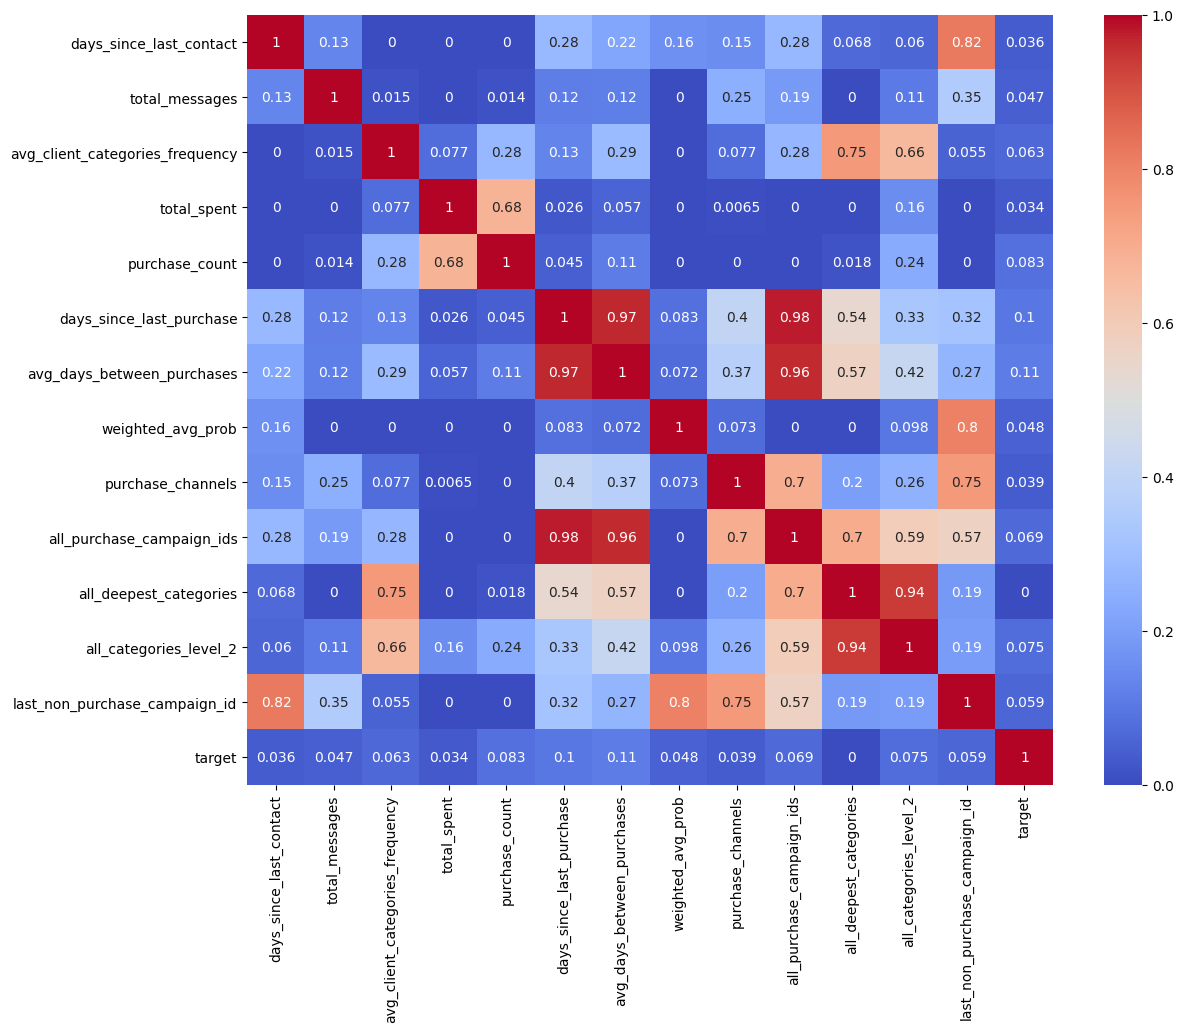

In [66]:
phik_matrix_topk = df_full.phik_matrix(interval_cols=num_columns)

plt.figure(figsize=(13, 10))
sns.heatmap(phik_matrix_topk, annot=True, cmap='coolwarm');


In [67]:
calculate_vif(df_full, df_full.select_dtypes(include=['number']).columns)

,Feature,VIF
0,days_since_last_contact,1.258266
1,total_messages,1.186895
2,avg_client_categories_frequency,1.334092
3,total_spent,1.371784
4,purchase_count,1.789687
5,days_since_last_purchase,1.859613
6,avg_days_between_purchases,1.942909
7,weighted_avg_prob,1.048496
8,target,1.012308


На матрице корреляции PhiK отмечается мультиколлинеарность:
- Высокая: all_purchase_campaign_ids и 2 других признака, но не будем его удалять.  
  Эти столбцы несут разный смысл, и all_purchase_campaign_ids может в целом обобщать интересы клиентов.
- Высокая: avg_days_between_purchases и days_since_last_purchase. Также оставим для обучения модели.
  Эти признаки могут коррелировать особенно в случаях, когда совершена всего одна покупка (в таком случае, столбцы отличаются на константу).
- Умеренная: last_non_purchase_campaign_id с рядом признаков. 

По количественным признакам отсутствуют высокие значения VIF.

## Разделение на выборки

В связи с сильным дисбалансом классов, при разделении данных на тренировочную и тестовую выборки применим стратификацию по таргету. 

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop(['target'], axis=1), 
    df_full['target'],
    test_size=TEST_SIZE,
    stratify=df_full['target'],
    random_state=RANDOM_STATE)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_train.columns
X_train.head(5)

,days_since_last_contact,total_messages,avg_client_categories_frequency,total_spent,purchase_count,days_since_last_purchase,avg_days_between_purchases,weighted_avg_prob,purchase_channels,all_purchase_campaign_ids,all_deepest_categories,all_categories_level_2,last_non_purchase_campaign_id
29523,4.0,681.0,1.38,1499.0,1,570,750,0.000007,mobile_push,5707,432,28,14648
13333,4.0,233.0,1.34,7006.0,4,224,404,0.000000,0,13427,0,28,14648
33335,4.0,233.0,1.62,1218.0,2,326,506,0.000000,0,0,1687,5589,14648
21009,6.0,105.0,1.45,1899.0,1,270,450,0.000005,email,12784,431,28,14641
47410,4.0,233.0,1.46,6018.0,2,289,469,0.000000,0,12367,1635,5589,14648


# Создание моделей

- **Задача**  
  Предсказать вероятность того, что клиент совершит покупку в течение ближайших 90 дней. Это поможет интернет-магазину точнее таргетировать рассылки и планировать маркетинговые активности.  

- **Тип задачи**  
  Задача с учителем (supervised learning), поскольку известен целевой признак (`target`) в обучающей выборке.

- **Тип машинного обучения**  
  Бинарная классификация, так как целевая переменная принимает два значения:
  - `1` — клиент совершит покупку в течение 90 дней
  - `0` — не совершит покупку

- **Выбор моделей**  
  Для решения задачи рассмотрим следующие алгоритмы:
  - `LogisticRegression` — базовая интерпретируемая модель.
  - `RandomForestClassifier` — ансамблевая модель, устойчивая к выбросам и переобучению.
  - `CatBoostClassifier` — бустинговая модель, хорошо работающая с категориальными признаками.

  Для каждой модели проведём подбор гиперпараметров с использованием `GridSearchCV`.

- **Метрика качества**

  Основная метрика:
  - **Recall (полнота)**  
    Показывает долю правильно предсказанных положительных классов среди всех реальных положительных.  
    Может быть полезна, если основная задача — не пропустить потенциальных покупателей, даже ценой ложных срабатываний.  

  Дополнительная метрика:
  - **ROC-AUC (Receiver Operating Characteristic - Area Under Curve)**  
    Показывает, насколько хорошо модель различает классы. Это особенно важно при несбалансированных классах, когда обычная точность может быть неинформативной.  
    В рамках данного проекта требуется максимизировать именно ROC-AUC согласно техническому заданию.


- **Пайплайн предобработки данных**

  Для построения модели будет использован `Pipeline`, включающий в себя предобработку признаков с помощью `ColumnTransformer`.

  **Числовые признаки (`num_columns`)**
  - Масштабирование с помощью `MinMaxScaler`

  **Категориальные признаки (`list_columns + cat_columns`)**
  - Для моделей `LogisticRegression` и `RandomForestClassifier`: `OneHotEncoder`
  - Для `CatBoostClassifier`: `'passthrough'`, так как CatBoost может обрабатывать категориальные признаки напрямую

## Обучение моделей

Создадим 2 пайплайна предобработки данных (с OHE и без).  
  

In [69]:
preprocessor_cat = ColumnTransformer(transformers=[
        ('num', MinMaxScaler(), num_columns),
        ('pass', 'passthrough', list_columns + cat_columns)],
        remainder='drop')

preprocessor_ohe = ColumnTransformer(transformers=[
        ('num', MinMaxScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), list_columns + cat_columns)],
        remainder='drop')


Зададим диапазоны перебора параметров для каждой модели отдельно.

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Для ускорения оставил только параметры, которые определялись как лучшие. Как вообще в таких случаях принято поступать в выложенном например на github проекте? Просто изначально надолго оставлял много параметров перебирать, потом что-то менял и т.п., не запускать же заново полный перебор, чтобы его "показать"? 
</div>

In [70]:
scoring = 'recall' 

grid_search_spaces = {
'log_reg': {
    'model': LogisticRegression(),
    'preprocessor': preprocessor_ohe,
    'param_grid': {'model__C': [0.01], 
                    'model__class_weight': [{0: 1, 1: 100}], 
                    'model__max_iter': [1000],
                    'model__penalty': ['l1'],
                    'model__solver': ['liblinear']}
},
'rfc': {
    'model': RandomForestClassifier(random_state=RANDOM_STATE),
    'preprocessor': preprocessor_ohe,
    'param_grid': {'model__class_weight': [{0: 1, 1: 100}],
                   'model__max_depth': [10],
                   'model__max_features': ['log2'],
                   'model__min_samples_leaf': [1],
                   'model__min_samples_split': [2],
                   'model__n_estimators': [200]}
     },
'catboost': {
    'model': CatBoostClassifier(random_state = RANDOM_STATE, 
                                verbose=False,
                                cat_features = all_cat_features_indices),
    'preprocessor': preprocessor_cat,
    'param_grid': {'model__bootstrap_type': ['Bernoulli'], 
                   'model__depth': [6], 
                   'model__early_stopping_rounds': [50], 
                   'model__grow_policy': ['SymmetricTree'],
                   'model__iterations': [1000], 
                   'model__l2_leaf_reg': [3], 
                   'model__learning_rate': [0.01], 
                   'model__min_data_in_leaf': [1], 
                   'model__scale_pos_weight': [100]}}
}

При помощи GridSearchCV определим лучшие параметры каждой модели.  

In [71]:
best_models = {}

for model_name, model_config in grid_search_spaces.items():
    
    start_time = time.time()
    formatted_time = datetime.fromtimestamp(start_time)
    print('=' * 60)
    print(f"Модель: {model_name}")
    print(f"Время начала: {formatted_time}")

    pipeline = Pipeline([
        ('preprocessor', model_config['preprocessor']),
        ('model', model_config['model'])
    ])

    grid_search = GridSearchCV(
        pipeline,
        model_config['param_grid'],
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
        n_jobs=-1,
        scoring=scoring,
        refit=True)
    
    grid_search.fit(X_train, y_train)
   
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)
    print(f"Общее время поиска параметров (с кросс-валидацией): {minutes} минут {seconds} секунд \n")
    
    print(f"Лучшие параметры для {model_name}:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    train_crossval_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)
    print(f"\n{scoring} кросс-валидация на тренировочной выборке: {train_crossval_score:.4f}")
    print(f"{scoring} на тестовой выборке: {test_score:.4f}")
    
    y_proba_train = grid_search.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train, y_proba_train)
    print(f"ROC-AUC на тренировочной выборке: {train_roc_auc:.4f}")
    
    y_pred = grid_search.predict(X_test)
    y_proba = grid_search.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC на тестовой выборке: {test_roc_auc:.4f}")

    best_models[model_name] = {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'grid_search': grid_search,
        'train_crossval_score': train_crossval_score,
        'test_score': test_score,
        'train_roc_auc': train_roc_auc,
        'test_roc_auc': test_roc_auc,
        'y_pred': y_pred,
        'y_proba': y_proba}

Модель: log_reg
Время начала: 2025-04-24 23:45:24.572953
Общее время поиска параметров (с кросс-валидацией): 0 минут 1 секунд 

Лучшие параметры для log_reg:
  model__C: 0.01
  model__class_weight: {0: 1, 1: 100}
  model__max_iter: 1000
  model__penalty: l1
  model__solver: liblinear

recall кросс-валидация на тренировочной выборке: 0.9545
recall на тестовой выборке: 0.9479
ROC-AUC на тренировочной выборке: 0.6986
ROC-AUC на тестовой выборке: 0.6957
Модель: rfc
Время начала: 2025-04-24 23:45:26.434394
Общее время поиска параметров (с кросс-валидацией): 0 минут 7 секунд 

Лучшие параметры для rfc:
  model__class_weight: {0: 1, 1: 100}
  model__max_depth: 10
  model__max_features: log2
  model__min_samples_leaf: 1
  model__min_samples_split: 2
  model__n_estimators: 200

recall кросс-валидация на тренировочной выборке: 1.0000
recall на тестовой выборке: 1.0000
ROC-AUC на тренировочной выборке: 0.7632
ROC-AUC на тестовой выборке: 0.6918
Модель: catboost
Время начала: 2025-04-24 23:45:36.3

## Анализ метрик полученных моделей


In [72]:
results_df = pd.DataFrame([
    {
        'Модель': model_name,
        'Recall (train)': round(metrics['train_crossval_score'], 4),
        'Recall (test)': round(metrics['test_score'], 4),
        'ROC-AUC (train)': round(metrics['train_roc_auc'], 4),
        'ROC-AUC (test)': round(metrics['test_roc_auc'], 4),
    }
    for model_name, metrics in best_models.items()
])

results_df

,Модель,Recall (train),Recall (test),ROC-AUC (train),ROC-AUC (test)
0,log_reg,0.9545,0.9479,0.6986,0.6957
1,rfc,1.0000,1.0000,0.7632,0.6918
2,catboost,0.9259,0.9375,0.7817,0.7165


**Анализ метрик полученных моделей**
- **Logistic Regression** показывает стабильные значения Recall и умеренный ROC-AUC, что говорит о сбалансированной, но не самой мощной модели.
- **Random Forest** демонстрирует идеальный Recall (1.0), но переобучается: ROC-AUC падает на тесте (0.6918), что указывает на слабую способность отличать классы на новых данных.
- **CatBoost** показывает наилучший результат по метрике **ROC-AUC на тестовой выборке (0.7165)**, что делает его предпочтительным выбором для задачи бинарной классификации по вероятности покупки.

**Выбор модели:**
**CatBoostClassifier** выбран в качестве финальной модели — он обеспечивает лучший баланс между обобщающей способностью и качеством предсказаний по ключевой метрике ROC-AUC.

**Параметры CatBoost**

- scale_pos_weight=100  
  Ключевой параметр! Балансирует вклад редкого положительного класса (например, ушедших клиентов или откликнувшихся на кампанию), увеличивая его вес. Значение подбиралось с учетом соотношения классов в данных.

- depth=6  
  Умеренная глубина дерева снижает риск переобучения, что важно при высокой диспропорции классов и ограниченном числе положительных примеров.

- l2_leaf_reg=3  
  Регуляризация для борьбы с переобучением, особенно актуальна при глубине >5.

- iterations=1000 + early_stopping_rounds=50  
  Даёт модели достаточно возможностей для обучения, но с остановкой по ухудшению на валидации, чтобы не переучиться.

- learning_rate=0.01  
  Низкая скорость обучения позволяет делать более точные шаги, что особенно важно при дисбалансе и высокой чувствительности к ошибкам.

- min_data_in_leaf=1  
  Учитывает даже очень малые подмножества — важно при редких положительных примерах.

- bootstrap_type='Bernoulli'  
  Использует стохастическую подвыборку (bagging), что помогает избежать переобучения и делает модель устойчивее.

- grow_policy='SymmetricTree'  
  Строит симметричные деревья — они быстрее обучаются и предсказывают, а также хорошо подходят при больших объёмах данных и низком уровне шума.

## Графики точности и полноты (Precision и Recall)

Для дополнительного анализа полученных моделей построим графики точности и полноты (Precision и Recall).  
Рассчитаем для каждой модели оптимальные пороги по метрике F4 и сравним метрики.  
В рамках задачи основная цель — максимизировать выявление положительного класса, при этом не сильно теряя точность, но приоритет — именно на recall (полноту).  
Это особенно актуально, потому что:
- позитивный класс редкий
- цена пропуска положительного случая может быть высока
- можно переработать с избыточным числом "ложных срабатываний", но минимизировать пропуски.  

F4-метрика как раз в 16 раз сильнее штрафует за низкую полноту, чем за точность, что делает её оптимальной при таком перекосе приоритетов.

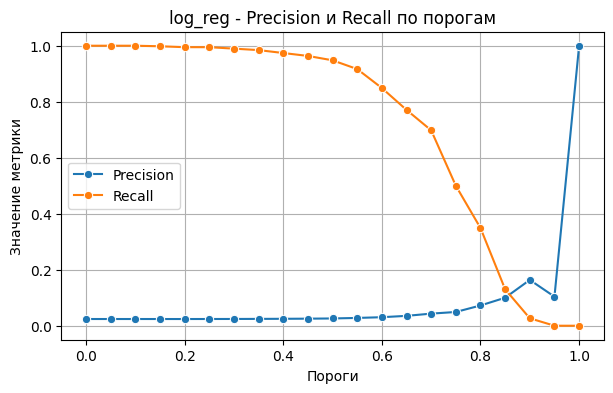


Наилучший порог модели log_reg F4: 0.71, F4: 0.3741, Recall: 0.6875, Precision: 0.0451


Метрики модели log_reg по порогам


,threshold,precision,recall,f1_score
0,0.00,0.023961,1.000000,0.046795
1,0.05,0.023961,1.000000,0.046795
2,0.10,0.023962,1.000000,0.046801
3,0.15,0.023931,0.998085,0.046829
4,0.20,0.023900,0.994792,0.046676
5,0.25,0.024018,0.994792,0.046900
6,0.30,0.024126,0.989583,0.047100
7,0.35,0.024388,0.984375,0.047595
8,0.40,0.024726,0.973958,0.048221
9,0.45,0.025189,0.963542,0.049091


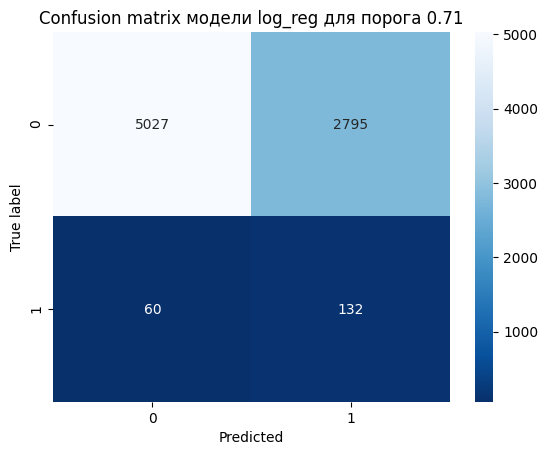

array([[5027, 2795],
       [  60,  132]], dtype=int64)

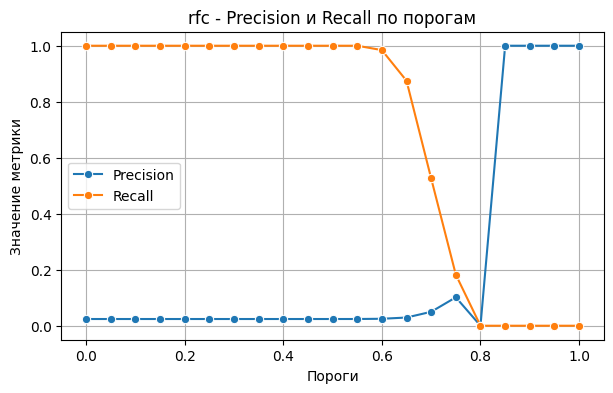


Наилучший порог модели rfc F4: 0.69, F4: 0.3581, Recall: 0.6354, Precision: 0.0449


Метрики модели rfc по порогам


,threshold,precision,recall,f1_score
0,0.00,0.023961,1.000000,0.046795
1,0.05,0.023961,1.000000,0.046795
2,0.10,0.023961,1.000000,0.046795
3,0.15,0.023961,1.000000,0.046795
4,0.20,0.023961,1.000000,0.046795
5,0.25,0.023961,1.000000,0.046795
6,0.30,0.023961,1.000000,0.046795
7,0.35,0.023961,1.000000,0.046795
8,0.40,0.023961,1.000000,0.046795
9,0.45,0.023961,1.000000,0.046795


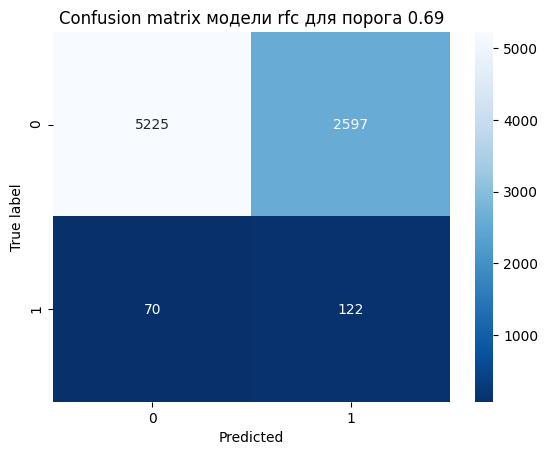

array([[5225, 2597],
       [  70,  122]], dtype=int64)

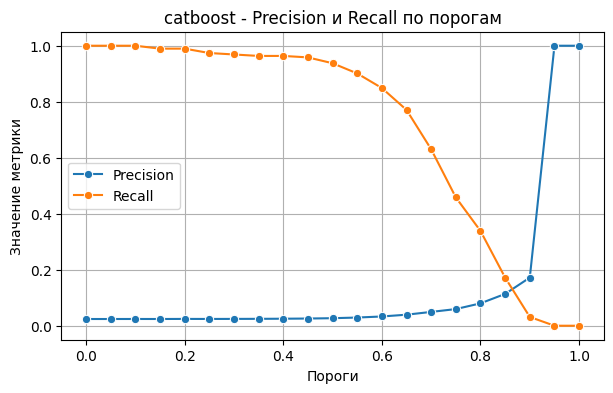


Наилучший порог модели catboost F4: 0.69, F4: 0.3838, Recall: 0.6719, Precision: 0.0488


Метрики модели catboost по порогам


,threshold,precision,recall,f1_score
0,0.00,0.023961,1.000000,0.046795
1,0.05,0.023981,1.000000,0.046835
2,0.10,0.024094,1.000000,0.047053
3,0.15,0.024016,0.989583,0.046890
4,0.20,0.024306,0.989583,0.047441
5,0.25,0.024186,0.973958,0.047198
6,0.30,0.024356,0.968750,0.047516
7,0.35,0.024586,0.963542,0.047946
8,0.40,0.025019,0.963542,0.048768
9,0.45,0.025663,0.958333,0.049986


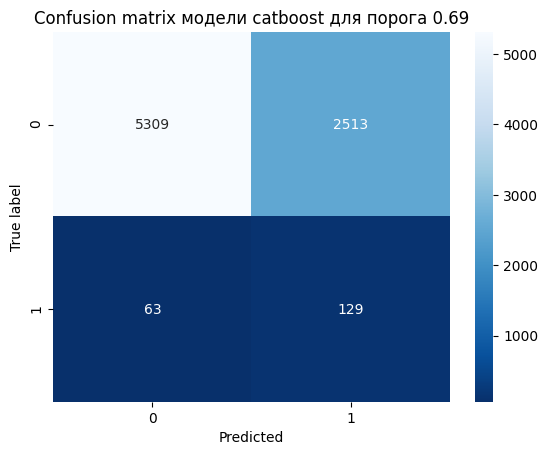

array([[5309, 2513],
       [  63,  129]], dtype=int64)

In [73]:
custom_thresholds = np.arange(0, 1.01, 0.05)

for model_name, predicts in best_models.items():
    print('='*90)
    precisions, recalls, thresholds = precision_recall_curve(y_test, predicts['y_proba'])
    # Интерполируем значения precision и recall на этих порогах
    # threshold → precision и recall (обратный порядок, потому что thresholds идут в возрастающем порядке, а recall убывает)
    precision_interp = np.interp(custom_thresholds, thresholds, precisions[1:])  # [1:] — чтобы длина совпадала
    recall_interp = np.interp(custom_thresholds, thresholds, recalls[1:])

    threshold_f1_scores = []  # Use a regular list for appending
    for thresh in custom_thresholds:
        y_pred_thresh = (predicts['y_proba'] >= thresh).astype(int)
        threshold_f1_scores.append(f1_score(y_test, y_pred_thresh))
    
    precisions_df = pd.DataFrame({
        'threshold': custom_thresholds,
        'precision': precision_interp,
        'recall': recall_interp,
        'f1_score': threshold_f1_scores  # Add the calculated F1 scores
    })
    
    plt.figure(figsize=(7, 4))
    sns.lineplot(x='threshold', y='precision', data=precisions_df, label='Precision', marker='o')
    sns.lineplot(x='threshold', y='recall', data=precisions_df, label='Recall', marker='o')
    
    plt.title(f'{model_name} - Precision и Recall по порогам')
    plt.xlabel('Пороги')
    plt.ylabel('Значение метрики')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Убираем точки, где precision + recall == 0, чтобы избежать деления на 0
    valid_mask = (precisions + recalls) > 0
    f1_scores = np.zeros_like(precisions)
    f1_scores[valid_mask] = 2 * (precisions[valid_mask] * recalls[valid_mask]) / (precisions[valid_mask] + recalls[valid_mask])
    
    # Ищем индекс по f_beta 
    beta = 4 
    f_beta_scores = np.zeros_like(precisions)
    valid_mask = (precisions + recalls) > 0
    f_beta_scores[valid_mask] = (1 + beta**2) * (precisions[valid_mask] * recalls[valid_mask]) / (
        beta**2 * precisions[valid_mask] + recalls[valid_mask]
    )
    best_idx = f_beta_scores.argmax()
    best_threshold = thresholds[best_idx]
    
    print(f"\nНаилучший порог модели {model_name} F{beta}: {best_threshold:.2f}, F{beta}: {f_beta_scores[best_idx]:.4f}, "
          f"Recall: {recalls[best_idx]:.4f}, Precision: {precisions[best_idx]:.4f}\n")

    print(f"\nМетрики модели {model_name} по порогам")
    display(precisions_df) # .head(15)) # .drop('precision', axis=1) #

    y_pred_custom = (predicts['y_proba'] >= best_threshold).astype(int)
    
    cm = confusion_matrix(y_test, y_pred_custom)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
    plt.ylabel('True label')
    plt.xlabel('Predicted')
    plt.title(f"Confusion matrix модели {model_name} для порога {best_threshold:.2f}")
    plt.show();
    display(cm)
    print('='*90)

## Выбор лучшей модели

**CatBoost** — лучшая модель по F4 (0.3838):  
Наилучший баланс между recall и precision, при этом высокая полнота (0.6719) и чуть лучшая точность (0.0488) среди моделей.
Относительно меньше ложных отрицательных (FN = 63), чем у RFC, и чуть больше TP, чем у LogReg.  

**LogReg** немного проигрывает CatBoost:  
Чуть выше recall (0.6875), но precision — ниже (0.0451).  
Наибольшее количество ложных срабатываний (FP = 2795), что вредит общей эффективности.  

**RFC** — наименее сбалансирован:  
Самый низкий recall среди трёх (0.6354).  
Precision такой же, как у LogReg.  
Общее число TP и F4-оценка — наименьшие.  

**Выводы**
Выбор модели и порога должен быть сделан в зависимости от того, насколько бизнес готов мириться с высоким количеством ложных срабатываний (FP) ради уменьшения пропусков (FN).

CatBoost с порогом 0.69 — оптимальный выбор, если цель — не упустить как можно больше реальных положительных объектов.

## Графики важности признаков

Для лучшей модели CatBoost построим графики важности признаков.  

In [74]:
model = best_models['catboost']['best_model'].named_steps['model']
importances = model.get_feature_importance()
preprocessor = best_models['catboost']['best_model'].named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

len(feature_names), feature_names

(13,
 array(['num__days_since_last_contact', 'num__total_messages',
        'num__avg_client_categories_frequency', 'num__total_spent',
        'num__purchase_count', 'num__days_since_last_purchase',
        'num__avg_days_between_purchases', 'num__weighted_avg_prob',
        'pass__purchase_channels', 'pass__all_purchase_campaign_ids',
        'pass__all_deepest_categories', 'pass__all_categories_level_2',
        'pass__last_non_purchase_campaign_id'], dtype=object))

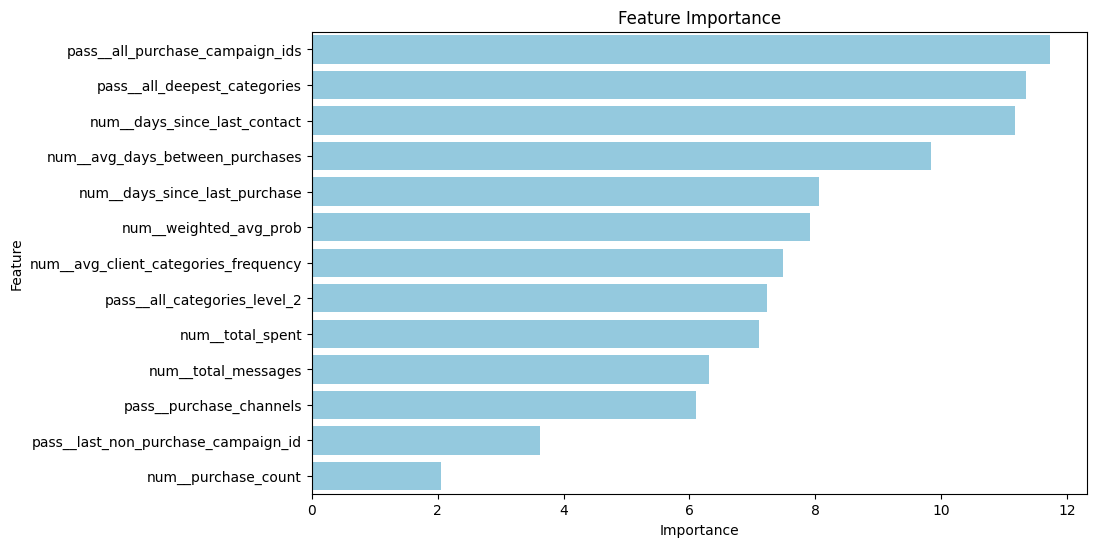

In [75]:
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, color='skyblue')
plt.title('Feature Importance')
plt.show()

In [76]:
importances_df

,Feature,Importance
9,pass__all_purchase_campaign_ids,11.728447
10,pass__all_deepest_categories,11.351971
0,num__days_since_last_contact,11.178524
6,num__avg_days_between_purchases,9.844118
5,num__days_since_last_purchase,8.057281
7,num__weighted_avg_prob,7.921545
2,num__avg_client_categories_frequency,7.491804
11,pass__all_categories_level_2,7.230702
3,num__total_spent,7.103810
1,num__total_messages,6.311673


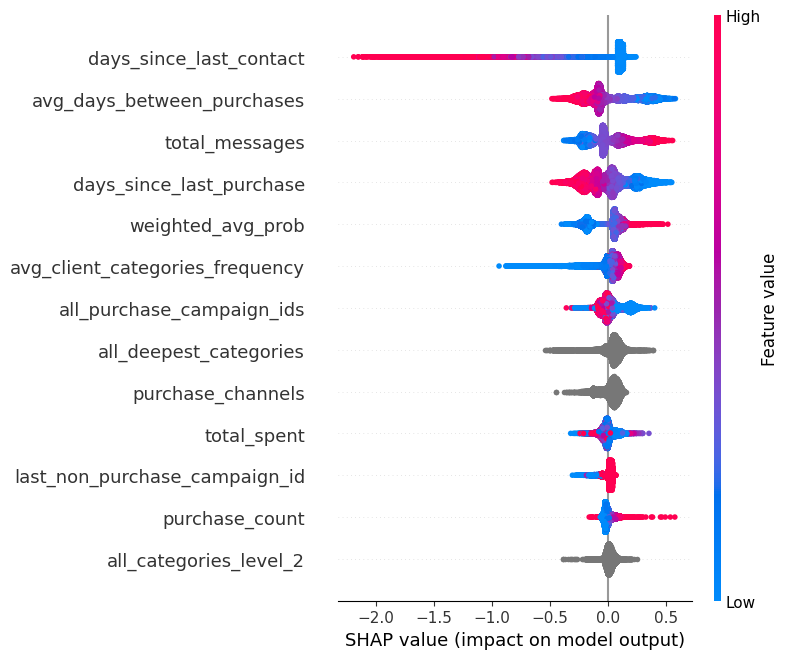

In [77]:
X_train_prepd = preprocessor.fit_transform(X_train)

# SHAP объяснитель для модели CatBoost
explainer = shap.Explainer(model)
shap_values = explainer(X_train_prepd)
feature_names = num_columns + list_columns + cat_columns 
shap.summary_plot(shap_values, X_train_prepd, feature_names=feature_names)

**Выводы по важности признаков (Feature Importance)**

Анализ важности признаков модели CatBoost показал, какие характеристики клиентов сильнее всего влияют на предсказание вероятности покупки в ближайшие 90 дней:

1. **ID предыдущих кампаний, на которые откликался клиент** (`all_purchase_campaign_ids`) — главный индикатор: если клиент уже реагировал на кампании, вероятность отклика в будущем выше.
2. **Самые глубокие категории, в которых клиент ранее совершал покупки** (`all_deepest_categories`) — помогает определить предпочтения и таргетировать кампанию точнее.
3. **Время с момента последнего контакта** (`days_since_last_contact`) — чем дольше с клиентом не контактировали, тем меньше шансов на покупку.
4. **Средний интервал между покупками** (`avg_days_between_purchases`) — отражает регулярность активности клиента. Чем меньше, тем больше шансов на покупку.
5. **Время с последней покупки** (`days_since_last_purchase`) — чем дольше клиент не покупал, тем ниже вероятность отклика. Чем меньше, тем больше шансов на покупку.
6. **Взвешенная вероятность интереса** (`weighted_avg_prob`) — взвешенная средняя вероятность покупки по каждой кампании рассылки, хорошо предсказывает вовлечённость.
7. **Частота покупок по категориям** (`avg_client_categories_frequency`) — условная частота повторных покупок по любимым категориям клиента. Сигнализирует о стабильности интересов клиента.
8. **Категории второго уровня** (`all_categories_level_2`) — дополнительная детализация интересов клиента, помогает точнее сегментировать аудиторию.
9. **Общая сумма покупок** (`total_spent`) — клиенты с высокой тратой, как правило, более лояльны и с большей вероятностью откликнутся на предложение.
10. **Количество полученных сообщений** (`total_messages`) — умеренное влияние: частые сообщения повышают шанс на покупку.
11. **Используемые клиентом каналы покупки** (`purchase_channels`) — даёт представление о предпочтениях в каналах, что важно для выбора формата коммуникации.
12. **ID последней кампании без покупки** (`last_non_purchase_campaign_id`) — может спрогнозировать вероятность заинтересованности кампанией.
13. **Общее количество покупок** (`purchase_count`) — наименее значимый признак: общее количество покупок менее информативно, вместе с тем, с увеличением количества, растет вероятность покупки.

**Бизнес-инсайт**:  
Для повышения эффективности маркетинговых кампаний важно фокусироваться на:
- Повторно вовлечённых клиентах (ранее откликнувшихся).
- Поведенчески активных клиентах (с регулярными покупками).
- Персонализации кампаний на основе любимых категорий.



# Общие выводы

**Задачи:**  
- Изучить данные  
- Разработать полезные признаки  
- Создать модель для классификации пользователей  
- Улучшить модель и максимизировать метрику ROC-AUC  
- Выполнить тестирование
  
**Описание проделанных шагов:**

1. **Анализ и предобработка данных:**
   - Удалено 73k дубликатов в покупках и 37k в рассылках
   - Преобразование `category_ids` в иерархические признаки (5 уровней)
   - Объединение редких категорий в группу "0"
   - Расчет временных характеристик относительно даты выгрузки (2024-02-19)

2. **Генерация признаков:**
   - **Покупки:**
     - Агрегация по клиентам: сумма покупок, частота, интервалы
     - Топ-3 категорий, deepest_category, каналы покупок
     - дней с момента последней покупки, среднее время между покупками
   - **Рассылки:**
     - Время с последнего контакта
     - ID кампании последнего контакта без покупки
     - взвешенная вероятность покупки по каждой кампании рассылки
   - Объединение данных из 4 источников

3. **Работа с дисбалансом:**
   - Undersampling мажорного класса 0 по наименее значимым категориям (рассчитанно по Target Encoding с кросс-валидацией)

4. **Моделирование:**
   - Тестирование LogisticRegression, RandomForest, CatBoost
   - Оптимизация ROC-AUC через GridSearchCV
   - Параметры CatBoost:
     ```
     CatBoostClassifier(
         scale_pos_weight=100,
         depth=6,
         l2_leaf_reg=3,
         iterations=1000,
         learning_rate=0.01,
         bootstrap_type='Bernoulli'
     )
     ```

5. **Оценка:**
   - Лучшая модель: CatBoost (ROC-AUC 0.7165)
   - Оптимальный порог: 0.69 (F4-метрика)
   - Важные признаки:
     1. История откликов на кампании
     2. Предпочтения в категориях
     3. Временные характеристики активности

**Итоговый вывод:**

**Результаты:**
- Качество модели: ROC-AUC 0.7165, Recall 93.75%
- Ключевые драйверы покупок:
  - Отклики на предыдущие кампании
  - Любимые категории товаров
  - Активность клиента

**Рекомендации:**
1. Персонализация рассылок по любимым категориям
2. Усиление коммуникации с неактивными клиентами
3. Приоритезация клиентов с историей откликов